### Init

In [2]:
import torch

def count_parameters(model):
    """
    計算模型的參數數量
    Returns:
      total_params: 包含所有參數
      trainable_params: 只包含 requires_grad=True 的參數
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

import io

def estimate_model_size(model):
    """
    將模型序列化到緩衝區，估算存檔大小（MB）
    """
    buffer = io.BytesIO()
    torch.save(model.state_dict(), buffer)
    size_mb = buffer.getbuffer().nbytes / (1024 ** 2)
    return size_mb

def show_network_status( orig_net, prune_net ):
    print( "原始網路參數統計:\n" )
    model = orig_net
    total, trainable = count_parameters(model)
    print(f"總參數量: {total:,}")
    print(f"可訓練參數量: {trainable:,}")

    size_mb = estimate_model_size(model)
    print(f"模型存儲大小: {size_mb:.2f} MB")

    print( "剪枝網路參數統計:\n" )
    model = prune_net
    total, trainable = count_parameters(model)
    print(f"總參數量: {total:,}")
    print(f"可訓練參數量: {trainable:,}")

    size_mb = estimate_model_size(model)
    print(f"模型存儲大小: {size_mb:.2f} MB")

In [3]:
import os
import argparse

import torch
import os
import argparse
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms

from os2d.modeling.model import build_os2d_from_config
from os2d.config import cfg
import  os2d.utils.visualization as visualizer
from os2d.structures.feature_map import FeatureMapSize
from os2d.utils import setup_logger, read_image, get_image_size_after_resize_preserving_aspect_ratio
from os2d.data import dataloader
from os2d.modeling.model import build_os2d_from_config

from os2d.data.dataloader import build_eval_dataloaders_from_cfg, build_train_dataloader_from_config
from os2d.engine.train import trainval_loop
from os2d.utils import set_random_seed, get_trainable_parameters, mkdir, save_config, setup_logger, get_data_path
from os2d.engine.optimization import create_optimizer
from os2d.config import cfg
from os2d.utils.visualization import *
import random
import os2d.utils.visualization as visualizer
from pathlib import Path
import cv2
import numpy as np
from os2d.utils import get_image_size_after_resize_preserving_aspect_ratio
from src.util.detection import generate_detection_boxes
from src.util.visualize import visualize_boxes_on_image
from src.util.filter import DataLoaderDB

In [4]:
from os2d.utils import setup_logger, read_image, get_image_size_after_resize_preserving_aspect_ratio

logger = setup_logger("OS2D")

In [5]:
if cfg.is_cuda:
    assert torch.cuda.is_available(), "Do not have available GPU, but cfg.is_cuda == 1"
    torch.backends.cudnn.benchmark = True

# random seed
set_random_seed(cfg.random_seed, cfg.is_cuda)

# Model
cfg.defrost()
cfg.init.model = './src/util/checkpoints-test/checkpoint_lcp_finetune_26_layer3.5.conv2.pth'
cfg.freeze()

# net = torch.load( cfg.init.model, map_location=torch.device('cuda') )
net, box_coder, criterion, img_normalization, optimizer_state = build_os2d_from_config(cfg)

# Optimizer
parameters = get_trainable_parameters(net)
optimizer = create_optimizer(parameters, cfg.train.optim, optimizer_state)

# load the dataset
data_path = get_data_path()
dataloader_train, datasets_train_for_eval = build_train_dataloader_from_config(cfg, box_coder, img_normalization,
                                                                                data_path=data_path)

dataloaders_eval = build_eval_dataloaders_from_cfg(cfg, box_coder, img_normalization,
                                                    datasets_for_eval=datasets_train_for_eval,
                                                    data_path=data_path)

db = DataLoaderDB( path = './src/db/data.csv' , dataloader = dataloader_train)

from src.lcp.ct_aoi_align import ContextAoiAlign
transform_image = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize(img_normalization["mean"], img_normalization["std"])
                      ])

context_aoi_align = ContextAoiAlign( db, dataloader_train, transform_image , net , cfg )

from src.lcp.aux_net import AuxiliaryNetwork
aux_net = AuxiliaryNetwork( context_aoi_align, db )

from src.util.prune_db import PruneDBControler
prune_db = PruneDBControler( path = './src/db/prune_channel_information.csv' )

from src.lcp.lcp import LCP
lcp = LCP(net, aux_net , dataloader_train)
lcp.init_for_indices()
lcp.set_prune_db( prune_db )

from src.lcp.pruner import Pruner
pruner = Pruner( lcp._prune_net )
pruner.set_prune_db( prune_db )

2025-07-18 15:34:58,413 OS2D INFO: Building the OS2D model
2025-07-18 15:34:58,784 OS2D INFO: Creating model on one GPU
2025-07-18 15:34:58,814 OS2D INFO: Reading model file ./src/util/checkpoints-test/checkpoint_lcp_finetune_26_layer3.5.conv2.pth
2025-07-18 15:34:58,852 OS2D INFO: Loaded feature extractor from checkpoint
2025-07-18 15:34:58,883 OS2D INFO: Restoring pruned parameters to original dimensions...
Found 40 total layers in database
Filtered to 20 layers starting with 'layer'
[LCP] 層級依賴分析完成 - net_feature_maps.layer1.0.conv1
      BatchNorm: net_feature_maps.layer1.0.bn1
      下游層級: 1 個
      跳躍連接: 0 個
[LCP] 層級依賴分析完成 - net_feature_maps.layer1.0.conv2
      BatchNorm: net_feature_maps.layer1.0.bn2
      下游層級: 1 個
      跳躍連接: 0 個
[LCP] 層級依賴分析完成 - net_feature_maps.layer1.1.conv1
      BatchNorm: net_feature_maps.layer1.1.bn1
      下游層級: 1 個
      跳躍連接: 0 個
[LCP] 層級依賴分析完成 - net_feature_maps.layer1.1.conv2
      BatchNorm: net_feature_maps.layer1.1.bn2
      下游層級: 1 個
      跳躍連接: 0

In [6]:
# from src.lcp.recontruction import LCPReconstruction
# lcp_reconstruction = LCPReconstruction(
#     prune_db = prune_db,
#     pruner = pruner,
#     prune_net = lcp._prune_net
# )

In [7]:
layers = prune_db.get_all_layers()
pruned_layers = []
for layer in layers:
    if layer not in pruned_layers and layer.startswith('layer'):
        pruned_layers.append(layer)

In [8]:
print( pruned_layers)

['layer1.0.conv1', 'layer1.0.conv2', 'layer1.1.conv1', 'layer1.1.conv2', 'layer1.2.conv1', 'layer1.2.conv2', 'layer2.0.conv1', 'layer2.0.conv2', 'layer2.1.conv1', 'layer2.1.conv2', 'layer2.2.conv1', 'layer2.2.conv2', 'layer2.3.conv1', 'layer2.3.conv2', 'layer3.0.conv2', 'layer3.1.conv2', 'layer3.2.conv2', 'layer3.3.conv2', 'layer3.4.conv2', 'layer3.5.conv2']


In [9]:
layers = lcp.get_layers_name()

for name, ch in layers:
    if name == 'layer1.0.conv1':
        pass
    else:
        continue
    print(f"{name}: {ch} channels")
    keep, discard = lcp.get_channel_selection_by_no_grad(
        layer_name   = f"net_feature_maps.{name}",
        discard_rate = 0.5,
        lambda_rate  = 1.0,
        use_image_num= 3,
        random_seed  = 42
    )
    print(f"layer {name} , 預計保留通道數量: {len(keep)}/{ch}, 預計捨棄通道數量: {len(discard)}/{ch}")

layer1.0.conv1: 64 channels
[LCP] 開始基於數學推導的無梯度通道重要性計算 - net_feature_maps.layer1.0.conv1
[438, 256, 372]
[LOG] 原始網路特徵提取完成
[LOG] 剪枝網路特徵提取完成
438 {'channels': [{'l1_norm': 3.224752902984619, 'variance': 0.33837005496025085, 'mean_deviation': 2.7685346603393555, 'energy': 10.737399101257324, 'sparsity': 0.0, 'importance': 1.4799408912658691}, {'l1_norm': 3.442218780517578, 'variance': 1.5704890489578247, 'mean_deviation': 2.9860005378723145, 'energy': 13.41934871673584, 'sparsity': 0.0, 'importance': 1.7324775457382202}, {'l1_norm': 0.0, 'variance': 0.0, 'mean_deviation': 0.45621830224990845, 'energy': 0.0, 'sparsity': 1.0, 'importance': 0.04979398474097252}, {'l1_norm': 0.0, 'variance': 0.0, 'mean_deviation': 0.45621830224990845, 'energy': 0.0, 'sparsity': 1.0, 'importance': 0.04979398474097252}, {'l1_norm': 3.998171091079712, 'variance': 5.718142032623291, 'mean_deviation': 3.4651975631713867, 'energy': 21.095605850219727, 'sparsity': 0.0, 'importance': 2.465763568878174}, {'l1_norm': 0.0

In [10]:
for layer in pruned_layers:
    lcp.prune_layer(
        layer_name   = layer,
        discard_rate = None,
    )

[PRUNE] 開始剪枝層級: layer1.0.conv1
=== net_feature_maps 詳細層級資訊 ===
[LCP] 層級依賴分析完成 - layer1.0.conv1
      BatchNorm: net_feature_maps.layer1.0.bn1
      下游層級: 1 個
      跳躍連接: 0 個
[PRUNE] 開始剪枝輸出通道: layer1.0.conv1
[PRUNE] 保留通道索引: [0, 1, 4, 7, 13, 14, 24, 29, 44, 54, 60, 62, 63]
[PRUNE] 保留通道數量: 13
[PRUNE] 原始輸出通道數: 64
[PRUNE] Conv2d 權重: torch.Size([64, 64, 1, 1]) -> torch.Size([13, 64, 1, 1])
[PRUNE] 更新 out_channels: 13
[PRUNE] 輸出通道剪枝完成: 64 -> 13
[PRUNE] 開始剪枝 BatchNorm 層: net_feature_maps.layer1.0.bn1
[PRUNE] BatchNorm 通道數變化: 64 -> 13
[PRUNE] BatchNorm weight 剪枝完成: torch.Size([13])
[PRUNE] BatchNorm bias 剪枝完成: torch.Size([13])
[PRUNE] BatchNorm running_mean 剪枝完成: torch.Size([13])
[PRUNE] BatchNorm running_var 剪枝完成: torch.Size([13])
[VALIDATE] BatchNorm 層 net_feature_maps.layer1.0.bn1 剪枝驗證通過
[PRUNE] BatchNorm 層 net_feature_maps.layer1.0.bn1 剪枝成功
[PRUNE] 修補 net_feature_maps.layer1.0.conv2 的輸入通道 (來源 layer1.0.conv1)
[PRUNE] Conv 輸入維度: torch.Size([64, 64, 3, 3]) → torch.Size([64, 13, 3, 3])
[0, 1, 4

In [11]:
show_network_status( net, lcp._prune_net )

原始網路參數統計:

總參數量: 10,169,478
可訓練參數量: 10,169,478
模型存儲大小: 39.05 MB
剪枝網路參數統計:

總參數量: 6,997,533
可訓練參數量: 6,997,533
模型存儲大小: 26.93 MB


image to show size: (3264, 2448), res


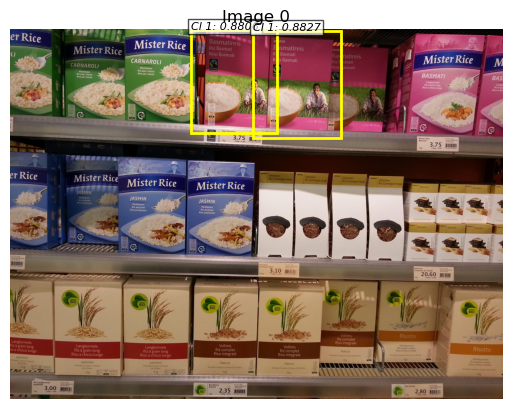

Image 0 size FeatureMapSize(w=3264, h=2448) has 30 boxes
Showing all GT boxes for image 0, dataset grozi-train


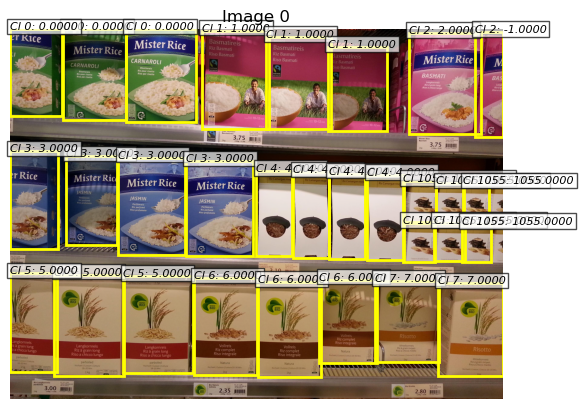

image to show size: (3264, 2448), res


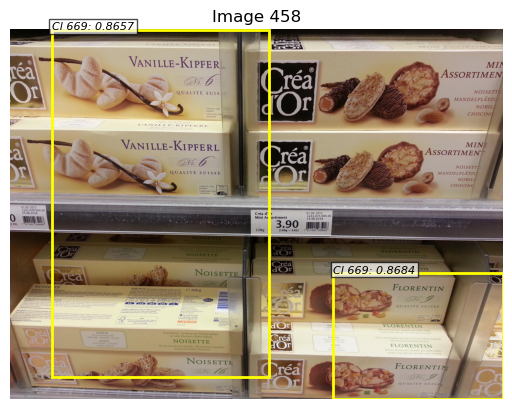

Image 458 size FeatureMapSize(w=3264, h=2448) has 8 boxes
Showing all GT boxes for image 458, dataset grozi-train


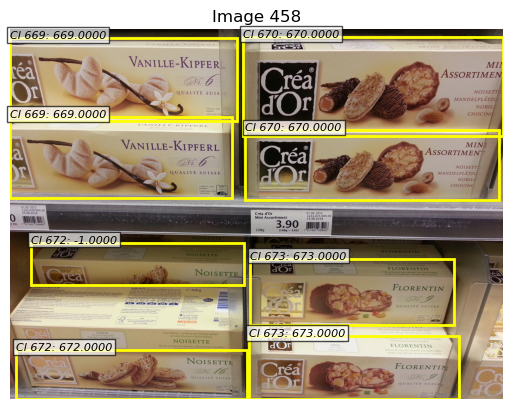

image to show size: (2448, 3264), res


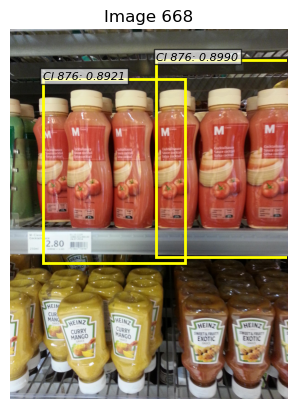

Image 668 size FeatureMapSize(w=2448, h=3264) has 11 boxes
Showing all GT boxes for image 668, dataset grozi-train


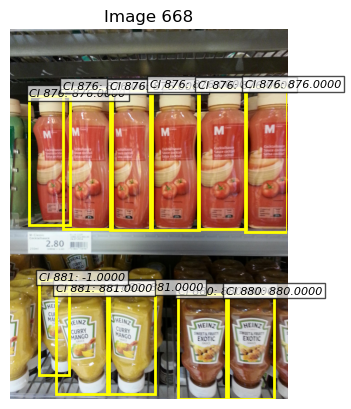

In [ ]:
for i in range( 20 ):
    lcp.debug_for_test_vision(
        dataloader_train = dataloader_train,
        img_normalization = img_normalization,
        box_coder = box_coder,
        cfg = cfg,
        count = 1
    )